In [12]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [13]:
temp_index = list(range(len(data)))
data['id'] = temp_index

In [14]:
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target']

df = data[selected_columns]
df.head()


,id,아파트명,전용면적(㎡),계약년월,계약일,층,구,동,건축년도,closest_bus_stop_distance,closest_subway_station_distance,bus_stop_count_500m,subway_station_count_500m,bus_stop_count_750m,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target
0,0,개포6차우성,79.97,2017-12-01,8,3,강남구,개포동,1987,95.560091,1187.188361,12,0,38,0,57,0,6.609733,0,124000.0
1,1,개포6차우성,79.97,2017-12-01,22,4,강남구,개포동,1987,95.560091,1187.188361,12,0,38,0,57,0,6.609733,0,123500.0
2,2,개포6차우성,54.98,2017-12-01,28,5,강남구,개포동,1987,95.560091,1187.188361,12,0,38,0,57,0,6.609733,0,91500.0
3,3,개포6차우성,79.97,2018-01-01,3,4,강남구,개포동,1987,95.560091,1187.188361,12,0,38,0,57,0,6.609733,0,130000.0
4,4,개포6차우성,79.97,2018-01-01,8,2,강남구,개포동,1987,95.560091,1187.188361,12,0,38,0,57,0,6.609733,0,117000.0


In [15]:
chunks = {}

df['지역'] = df.apply(lambda x: x['구']+' '+ x['동'], axis=1)

regions = list(df['지역'].unique())

for region in regions:
    chunk = df[df['지역'] == region]
    chunk['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))
    chunk.drop(columns=['구', '동'], axis=1, inplace=True)
    chunks[region] = chunk.sort_values(by='계약년월')


In [16]:
from IPython.display import display
from tqdm import tqdm
import pandas as pd

for region in tqdm(regions):
    chunk = chunks[region]

    # 테스트 데이터 제외
    train_data = chunk[chunk['is_test'] == 0]

    # 1. 올해 이 지역 평균
    yearly_mean = train_data.groupby('계약년')['target'].mean()
    chunk['올해 이 지역 평균'] = chunk['계약년'].map(yearly_mean)

    # 2. 올해 이 아파트 평균
    apart_mean = train_data.groupby(['계약년', '아파트명'])['target'].mean()
    chunk['올해 이 아파트 평균'] = chunk.set_index(['계약년', '아파트명']).index.map(apart_mean)

    # 3. 올해 해당 집 유형들의 평균
    type_mean = train_data.groupby(['계약년', '아파트명', '전용면적(㎡)'])['target'].mean()
    chunk['올해 해당 집 유형들의 평균'] = chunk.set_index(['계약년', '아파트명', '전용면적(㎡)']).index.map(type_mean)

    # 4. 평균 부정확도
    chunk['평균 부정확도'] = 0

    chunks[region] = chunk

100%|██████████| 339/339 [00:02<00:00, 113.44it/s]


In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def fill_na(sample):
    region_mean = sample['올해 이 지역 평균']
    apart_mean = sample['올해 이 아파트 평균']
    house_mean = sample['올해 해당 집 유형들의 평균']

    if pd.isnull(apart_mean):
        sample['올해 이 아파트 평균'] = region_mean
        sample['평균 부정확도'] = 2

    if pd.isnull(house_mean):
        if pd.isnull(apart_mean):
            sample['올해 해당 집 유형들의 평균'] = region_mean
            sample['평균 부정확도'] = 3
        else:
            sample['올해 해당 집 유형들의 평균'] = apart_mean
            sample['평균 부정확도'] = 1

    return sample

for region in tqdm(regions):
    chunk = chunks[region]
    chunk = chunk.apply(fill_na, axis=1)
    chunks[region] = chunk

100%|██████████| 339/339 [00:28<00:00, 11.93it/s]


In [18]:
null_regions = []
cnt = 0
for region in regions:
    select_cols = [col for col in chunks[region].columns if col != 'target']

    if sum(chunks[region][select_cols].isnull().sum()) != 0:
        null_regions.append(region)
        print(region)
        print(chunks[region][select_cols].isnull().sum())
        print('-' * 100)
        cnt += 1

print(cnt)

성동구 홍익동
id                                 0
아파트명                               0
전용면적(㎡)                            0
계약년월                               0
계약일                                0
층                                  0
건축년도                               0
closest_bus_stop_distance          0
closest_subway_station_distance    0
bus_stop_count_500m                0
subway_station_count_500m          0
bus_stop_count_750m                0
subway_station_count_750m          0
bus_stop_count_1000m               0
subway_station_count_1000m         0
distance_to_lead_house             0
is_test                            0
지역                                 0
계약년                                0
올해 이 지역 평균                         2
올해 이 아파트 평균                        2
올해 해당 집 유형들의 평균                    2
평균 부정확도                            0
dtype: int64
----------------------------------------------------------------------------------------------------
성북구 동선동4가
id               

In [19]:
# 두번째 결측치 처리
second_null_regions = []

for null_region in null_regions:
    temp_df = chunks[null_region]

    for idx, row in temp_df[temp_df.isnull().any(axis=1)].iterrows():

        year = 2022
        penalty = 4
        apart_name = row['아파트명']
        apart_size = row['전용면적(㎡)']

        region_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) , '올해 이 지역 평균'].mean()
        apart_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) & (temp_df['아파트명'] == apart_name), '올해 이 아파트 평균'].mean()
        house_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) & (temp_df['아파트명'] == apart_name) & (temp_df['전용면적(㎡)'] == apart_size), '올해 해당 집 유형들의 평균'].mean()

        while pd.isnull(region_target_mean):
            year -= 1
            region_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) , '올해 이 지역 평균'].mean()
            apart_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) & (temp_df['아파트명'] == apart_name), '올해 이 아파트 평균'].mean()
            house_target_mean = temp_df.loc[(temp_df['is_test'] == 0) & (temp_df['계약년'] == year) & (temp_df['아파트명'] == apart_name) & (temp_df['전용면적(㎡)'] == apart_size), '올해 해당 집 유형들의 평균'].mean()
            penalty += 4

        temp_df.loc[idx, '올해 이 지역 평균'] = region_target_mean
        temp_df.loc[idx, '올해 이 아파트 평균'] = apart_target_mean 
        temp_df.loc[idx, '올해 해당 집 유형들의 평균'] = house_target_mean
        temp_df.loc[idx, '평균 부정확도'] = penalty

        if pd.isnull(apart_target_mean):
            temp_df.loc[idx, '올해 이 아파트 평균'] = region_target_mean
            temp_df.loc[idx, '평균 부정확도'] = penalty + 1
        
        if pd.isnull(house_target_mean):
            if pd.isnull(apart_target_mean):
                temp_df.loc[idx, '올해 해당 집 유형들의 평균'] = region_target_mean
                temp_df.loc[idx, '평균 부정확도'] = penalty + 3
            else:
                temp_df.loc[idx, '올해 해당 집 유형들의 평균'] = apart_target_mean
                temp_df.loc[idx, '평균 부정확도'] = penalty + 2

    chunks[null_region] = temp_df

# 학습하고 예측해보자!!

In [20]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

result = pd.DataFrame()

result_board = []

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

regions_have_empty_test = []

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id', '전용면적(㎡)', '층', '건축년도',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', '계약년',
        '올해 이 지역 평균', '올해 이 아파트 평균', '올해 해당 집 유형들의 평균', '평균 부정확도', 'target', 'is_test']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    fold_cnt = (len(train_chunk) // 1000)
    fold_cnt = max(fold_cnt, 2)

    tscv = TimeSeriesSplit(n_splits = fold_cnt)

    if region == '중구 입정동':
        one_target = train_chunk['target']
        test_chunk['target'] = one_target
        result = pd.concat([result, test_chunk[['id', 'target']]])
        continue

    if len(test_chunk) == 0:
        regions_have_empty_test.append(region)
        continue

    if len(train_chunk) == 0:
        print("!!!!!!!!")
        print(f"{region}의 학습 데이터가 비어있어요!!!")
        print("!" * 100)
        

    train_chunk.drop(columns = ['is_test', 'id'], axis=1, inplace=True)
    test_chunk.drop(columns = ['is_test'], axis=1, inplace=True)
    
    X = train_chunk.drop(columns = ['target'], axis=1)
    y = train_chunk['target']

    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 

  0%|          | 0/339 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's rmse: 6934.76	valid_1's rmse: 9737.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	training's rmse: 8421.09	valid_1's rmse: 11048
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[293]	training's rmse: 8416.98	valid_1's rmse: 9538.22
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[405]	training's rmse: 8375.51	valid_1's rmse: 7192.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[466]	training's rmse: 7995.34	valid_1's rmse: 3314.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[513]	training's rmse: 7354.26	valid_1's rmse: 3947.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[514]	tr

  0%|          | 1/339 [00:10<58:31, 10.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[477]	training's rmse: 4676.38	valid_1's rmse: 21526.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[908]	training's rmse: 7464.85	valid_1's rmse: 9804.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1176]	training's rmse: 7385.3	valid_1's rmse: 14051.3


  1%|          | 2/339 [00:16<43:23,  7.73s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[416]	training's rmse: 8133.37	valid_1's rmse: 15002.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[474]	training's rmse: 9990.59	valid_1's rmse: 10977.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[568]	training's rmse: 9303.99	valid_1's rmse: 6477.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[769]	training's rmse: 8037.76	valid_1's rmse: 6869.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[818]	training's rmse: 7619.03	valid_1's rmse: 5555.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1043]	training's rmse: 6967.27	valid_1's rmse: 7578.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106

  1%|          | 3/339 [00:28<55:41,  9.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[704]	training's rmse: 13857	valid_1's rmse: 12438.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[761]	training's rmse: 12016.1	valid_1's rmse: 10819.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[844]	training's rmse: 10590	valid_1's rmse: 7851.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1322]	training's rmse: 8320.86	valid_1's rmse: 7988.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1456]	training's rmse: 7961.86	valid_1's rmse: 9284.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1508]	training's rmse: 8043.42	valid_1's rmse: 8400.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1509]

  1%|          | 4/339 [00:46<1:13:28, 13.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[345]	training's rmse: 12872.5	valid_1's rmse: 7672.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1188]	training's rmse: 6617.59	valid_1's rmse: 7819.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1265]	training's rmse: 6768.28	valid_1's rmse: 10284.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1689]	training's rmse: 6315.53	valid_1's rmse: 22414.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1875]	training's rmse: 10246.4	valid_1's rmse: 23309.4


  1%|▏         | 5/339 [00:59<1:12:14, 12.98s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[450]	training's rmse: 3113.1	valid_1's rmse: 9021
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1057]	training's rmse: 3217.75	valid_1's rmse: 27452.5


  2%|▏         | 6/339 [01:04<56:06, 10.11s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[348]	training's rmse: 3558.43	valid_1's rmse: 3261.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[364]	training's rmse: 3330.26	valid_1's rmse: 4707.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1512]	training's rmse: 2757.9	valid_1's rmse: 22006.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1972]	training's rmse: 4715.1	valid_1's rmse: 21386.5


  2%|▏         | 7/339 [01:15<57:40, 10.42s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[627]	training's rmse: 11482.8	valid_1's rmse: 19193.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[868]	training's rmse: 9022.29	valid_1's rmse: 51992.9


  2%|▏         | 8/339 [01:18<44:56,  8.15s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[424]	training's rmse: 3997.86	valid_1's rmse: 5806.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[612]	training's rmse: 3667.34	valid_1's rmse: 3877.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[613]	training's rmse: 3736.3	valid_1's rmse: 3099.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[870]	training's rmse: 3237.38	valid_1's rmse: 3750.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[892]	training's rmse: 3310.67	valid_1's rmse: 4357.72
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1471]	training's rmse: 3102.24	valid_1's rmse: 10430.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1911

  3%|▎         | 9/339 [01:36<1:01:43, 11.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[327]	training's rmse: 14205.2	valid_1's rmse: 13394.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[415]	training's rmse: 12974.1	valid_1's rmse: 10069.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[507]	training's rmse: 11415.1	valid_1's rmse: 26724
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[904]	training's rmse: 11853.2	valid_1's rmse: 56494


  3%|▎         | 10/339 [01:42<52:05,  9.50s/it] 

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[315]	training's rmse: 5869.87	valid_1's rmse: 4244.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[332]	training's rmse: 5006.63	valid_1's rmse: 5884.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[333]	training's rmse: 5308.88	valid_1's rmse: 55598.2


  3%|▎         | 11/339 [01:44<39:15,  7.18s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[518]	training's rmse: 3975.33	valid_1's rmse: 18623.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1150]	training's rmse: 5424.9	valid_1's rmse: 30081.3


  4%|▎         | 12/339 [01:48<34:27,  6.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1440]	training's rmse: 7159.85	valid_1's rmse: 15668
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1721]	training's rmse: 9468.98	valid_1's rmse: 9508.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1903]	training's rmse: 8479.55	valid_1's rmse: 15924.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2177]	training's rmse: 9607.13	valid_1's rmse: 63000.2


  4%|▍         | 13/339 [02:01<45:36,  8.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	training's rmse: 1614.83	valid_1's rmse: 9858.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[669]	training's rmse: 1429.43	valid_1's rmse: 2742.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[670]	training's rmse: 1959.37	valid_1's rmse: 24744.1


  4%|▍         | 14/339 [02:05<38:07,  7.04s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[575]	training's rmse: 3818.36	valid_1's rmse: 11375.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[649]	training's rmse: 6161.75	valid_1's rmse: 2942.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[721]	training's rmse: 4735.22	valid_1's rmse: 4903.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[818]	training's rmse: 4087.21	valid_1's rmse: 10938.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1054]	training's rmse: 4736.48	valid_1's rmse: 19798.2


  5%|▍         | 16/339 [02:13<30:14,  5.62s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[247]	training's rmse: 2178.71	valid_1's rmse: 2585.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[483]	training's rmse: 1931.67	valid_1's rmse: 1496.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[632]	training's rmse: 1677.54	valid_1's rmse: 1306.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[929]	training's rmse: 1462.6	valid_1's rmse: 1792.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1001]	training's rmse: 1492.54	valid_1's rmse: 2114.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1002]	training's rmse: 1611.43	valid_1's rmse: 4624.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[173

  5%|▌         | 17/339 [02:31<46:33,  8.67s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[476]	training's rmse: 4864.95	valid_1's rmse: 5997.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[575]	training's rmse: 4578.95	valid_1's rmse: 3564.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[661]	training's rmse: 4107.78	valid_1's rmse: 2413.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[757]	training's rmse: 3646.82	valid_1's rmse: 3335.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[758]	training's rmse: 3584.69	valid_1's rmse: 5730.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1087]	training's rmse: 3608.49	valid_1's rmse: 18099.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149

  5%|▌         | 18/339 [02:45<54:08, 10.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	training's rmse: 5166.93	valid_1's rmse: 6710.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[295]	training's rmse: 4776.47	valid_1's rmse: 2568.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[678]	training's rmse: 3582.1	valid_1's rmse: 2154.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[798]	training's rmse: 3223.47	valid_1's rmse: 2006.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[873]	training's rmse: 2971.84	valid_1's rmse: 2649.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[874]	training's rmse: 2918.77	valid_1's rmse: 4952.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[875]	

  6%|▌         | 19/339 [02:57<56:08, 10.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[319]	training's rmse: 4727	valid_1's rmse: 3096.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[457]	training's rmse: 3765	valid_1's rmse: 2964.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[458]	training's rmse: 3515.22	valid_1's rmse: 5184.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[785]	training's rmse: 3597.38	valid_1's rmse: 40775.6


  6%|▌         | 20/339 [03:02<48:35,  9.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[331]	training's rmse: 3308.05	valid_1's rmse: 3569.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[582]	training's rmse: 2272.22	valid_1's rmse: 2538.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1019]	training's rmse: 1880	valid_1's rmse: 1947.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1658]	training's rmse: 1580.88	valid_1's rmse: 3028.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1945]	training's rmse: 1674.25	valid_1's rmse: 4964.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2341]	training's rmse: 1955	valid_1's rmse: 8601.59


  6%|▌         | 21/339 [03:22<1:04:45, 12.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[506]	training's rmse: 2973.85	valid_1's rmse: 5175.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[579]	training's rmse: 3543.51	valid_1's rmse: 2856.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[702]	training's rmse: 2965.44	valid_1's rmse: 2139.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[914]	training's rmse: 2563.37	valid_1's rmse: 2103.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1032]	training's rmse: 2407.09	valid_1's rmse: 2206.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1164]	training's rmse: 2309.02	valid_1's rmse: 3543.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11

  6%|▋         | 22/339 [03:43<1:17:39, 14.70s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[902]	training's rmse: 1298.05	valid_1's rmse: 4798.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1115]	training's rmse: 2110.02	valid_1's rmse: 2072.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1344]	training's rmse: 1920.34	valid_1's rmse: 1481.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1429]	training's rmse: 1775.87	valid_1's rmse: 2623.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1503]	training's rmse: 1859.45	valid_1's rmse: 4988.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1895]	training's rmse: 1874.1	valid_1's rmse: 6401.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[284

  7%|▋         | 23/339 [04:12<1:39:35, 18.91s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[377]	training's rmse: 1727.91	valid_1's rmse: 2369.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[627]	training's rmse: 1818.11	valid_1's rmse: 1944.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[810]	training's rmse: 1646.41	valid_1's rmse: 1799.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[934]	training's rmse: 1617.61	valid_1's rmse: 1383.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[962]	training's rmse: 1559.21	valid_1's rmse: 1630.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[963]	training's rmse: 1570.35	valid_1's rmse: 1998.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[992]	t

  7%|▋         | 24/339 [04:38<1:50:24, 21.03s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[341]	training's rmse: 2391.25	valid_1's rmse: 1733.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[408]	training's rmse: 1994.95	valid_1's rmse: 1254.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[600]	training's rmse: 1641.07	valid_1's rmse: 1498.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[666]	training's rmse: 1571.92	valid_1's rmse: 2503.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1556]	training's rmse: 1565.19	valid_1's rmse: 8652.5


  7%|▋         | 25/339 [04:55<1:44:17, 19.93s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[535]	training's rmse: 2166.39	valid_1's rmse: 2667.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[608]	training's rmse: 2211.7	valid_1's rmse: 2316.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[609]	training's rmse: 2242.24	valid_1's rmse: 3822.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1159]	training's rmse: 1723.91	valid_1's rmse: 1715.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1167]	training's rmse: 1714.74	valid_1's rmse: 2490.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1168]	training's rmse: 1864.26	valid_1's rmse: 3259.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15

  8%|▊         | 26/339 [05:23<1:55:57, 22.23s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[276]	training's rmse: 1929.21	valid_1's rmse: 2371.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[332]	training's rmse: 2058	valid_1's rmse: 2053.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[916]	training's rmse: 1706.76	valid_1's rmse: 8405.4


  8%|▊         | 27/339 [05:31<1:34:00, 18.08s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1134]	training's rmse: 3456.06	valid_1's rmse: 4851.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1373]	training's rmse: 3274.83	valid_1's rmse: 9128.67


  8%|▊         | 28/339 [05:35<1:11:57, 13.88s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1944]	training's rmse: 1756.69	valid_1's rmse: 4031.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2194]	training's rmse: 2300.99	valid_1's rmse: 2839.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2583]	training's rmse: 2102.3	valid_1's rmse: 2299.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2584]	training's rmse: 2150.89	valid_1's rmse: 3159.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2876]	training's rmse: 2162.44	valid_1's rmse: 4493.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3175]	training's rmse: 2199.44	valid_1's rmse: 7958.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:


  9%|▊         | 29/339 [06:17<1:54:54, 22.24s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	training's rmse: 5651.73	valid_1's rmse: 5111.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[380]	training's rmse: 2747.6	valid_1's rmse: 1822.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[381]	training's rmse: 2476.42	valid_1's rmse: 2010.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[676]	training's rmse: 2090.14	valid_1's rmse: 2175.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[677]	training's rmse: 2105.82	valid_1's rmse: 3380.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[678]	training's rmse: 2363.93	valid_1's rmse: 2641.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[679]	

  9%|▉         | 30/339 [06:35<1:47:10, 20.81s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[280]	training's rmse: 2707.68	valid_1's rmse: 4116.66
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[903]	training's rmse: 1873.02	valid_1's rmse: 14498.8


  9%|▉         | 31/339 [06:38<1:20:27, 15.67s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[541]	training's rmse: 2579.25	valid_1's rmse: 15536.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1071]	training's rmse: 3419.19	valid_1's rmse: 13856.3


  9%|▉         | 32/339 [06:50<1:13:32, 14.37s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[426]	training's rmse: 1609.71	valid_1's rmse: 2433.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[585]	training's rmse: 1650.32	valid_1's rmse: 1666.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[627]	training's rmse: 1607.07	valid_1's rmse: 1540.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[710]	training's rmse: 1533.6	valid_1's rmse: 1693.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[741]	training's rmse: 1522.53	valid_1's rmse: 1621.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[742]	training's rmse: 1538.45	valid_1's rmse: 2829.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[743]	t

 10%|▉         | 33/339 [07:16<1:31:32, 17.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[352]	training's rmse: 2169.09	valid_1's rmse: 2394.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[411]	training's rmse: 2089.7	valid_1's rmse: 1793.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[722]	training's rmse: 1686.63	valid_1's rmse: 1632.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[780]	training's rmse: 1640.82	valid_1's rmse: 2032
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[822]	training's rmse: 1679.6	valid_1's rmse: 2253.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[824]	training's rmse: 1785.31	valid_1's rmse: 2266.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[825]	trai

 10%|█         | 34/339 [07:41<1:42:31, 20.17s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[349]	training's rmse: 1891.07	valid_1's rmse: 3228.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[414]	training's rmse: 2317.51	valid_1's rmse: 2635.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[475]	training's rmse: 2224.28	valid_1's rmse: 2406.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[805]	training's rmse: 2003.34	valid_1's rmse: 1732.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1876.63	valid_1's rmse: 2127.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[956]	training's rmse: 1918.88	valid_1's rmse: 2070.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[996]

 10%|█         | 35/339 [08:11<1:56:42, 23.03s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[395]	training's rmse: 2786.75	valid_1's rmse: 2781.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[765]	training's rmse: 2118.42	valid_1's rmse: 8451.27


 11%|█         | 36/339 [08:19<1:33:19, 18.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[356]	training's rmse: 1769.38	valid_1's rmse: 2167.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[447]	training's rmse: 1824.59	valid_1's rmse: 2536.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[479]	training's rmse: 2031.78	valid_1's rmse: 2355.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[581]	training's rmse: 1992.03	valid_1's rmse: 1888.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[646]	training's rmse: 1931.8	valid_1's rmse: 2569.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[647]	training's rmse: 2050.43	valid_1's rmse: 1816.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[704]	

 11%|█         | 37/339 [08:48<1:48:22, 21.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[284]	training's rmse: 2131.28	valid_1's rmse: 2921.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[514]	training's rmse: 2035.22	valid_1's rmse: 2259.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[826]	training's rmse: 1884.12	valid_1's rmse: 1901.26
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[827]	training's rmse: 1887.71	valid_1's rmse: 1890.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[964]	training's rmse: 1792.36	valid_1's rmse: 1514.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1043]	training's rmse: 1721.67	valid_1's rmse: 1452.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104

 11%|█         | 38/339 [09:19<2:02:24, 24.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[503]	training's rmse: 4125.46	valid_1's rmse: 6440.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[621]	training's rmse: 4839.27	valid_1's rmse: 3780.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[668]	training's rmse: 4401.62	valid_1's rmse: 4094.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[690]	training's rmse: 4260.49	valid_1's rmse: 4740.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[691]	training's rmse: 4355.93	valid_1's rmse: 8272.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1004]	training's rmse: 4428.96	valid_1's rmse: 19041.5


 12%|█▏        | 39/339 [09:30<1:41:56, 20.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[301]	training's rmse: 4408.19	valid_1's rmse: 2780.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[330]	training's rmse: 3584.96	valid_1's rmse: 3390.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[379]	training's rmse: 3333.52	valid_1's rmse: 5210.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[381]	training's rmse: 3877.57	valid_1's rmse: 17763.3


 12%|█▏        | 40/339 [09:34<1:17:12, 15.49s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[425]	training's rmse: 3527.01	valid_1's rmse: 6663.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[561]	training's rmse: 4233.87	valid_1's rmse: 5078.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[813]	training's rmse: 3838.43	valid_1's rmse: 3468.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[835]	training's rmse: 3663.52	valid_1's rmse: 3957.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[938]	training's rmse: 3516.88	valid_1's rmse: 4435.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[939]	training's rmse: 3683.46	valid_1's rmse: 6642.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[947]

 12%|█▏        | 41/339 [09:49<1:17:21, 15.57s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[775]	training's rmse: 3532.12	valid_1's rmse: 3743.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[776]	training's rmse: 3627.56	valid_1's rmse: 17706.4


 12%|█▏        | 42/339 [09:53<59:19, 11.99s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[636]	training's rmse: 1074.72	valid_1's rmse: 5873.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1068]	training's rmse: 1304.81	valid_1's rmse: 6492.38


 13%|█▎        | 43/339 [09:59<50:47, 10.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[418]	training's rmse: 1612.56	valid_1's rmse: 2765.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[719]	training's rmse: 1734.68	valid_1's rmse: 1884.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[724]	training's rmse: 1779.05	valid_1's rmse: 1939.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[825]	training's rmse: 1704.26	valid_1's rmse: 1706.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[855]	training's rmse: 1660.06	valid_1's rmse: 1814.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1132]	training's rmse: 1528.62	valid_1's rmse: 1662.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148

 13%|█▎        | 44/339 [10:32<1:23:13, 16.93s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[674]	training's rmse: 1545.85	valid_1's rmse: 2339.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[818]	training's rmse: 1733.49	valid_1's rmse: 1479.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[892]	training's rmse: 1552.83	valid_1's rmse: 1491.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1090]	training's rmse: 1415.44	valid_1's rmse: 1659.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1091]	training's rmse: 1466.7	valid_1's rmse: 1961.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1092]	training's rmse: 1558.23	valid_1's rmse: 4794.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146

 13%|█▎        | 45/339 [10:49<1:23:58, 17.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[336]	training's rmse: 1859.65	valid_1's rmse: 1532.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[648]	training's rmse: 1180.11	valid_1's rmse: 6877.98


 14%|█▎        | 46/339 [10:54<1:04:56, 13.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[518]	training's rmse: 1400.59	valid_1's rmse: 2073.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[519]	training's rmse: 1762.92	valid_1's rmse: 2374.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[527]	training's rmse: 1947.72	valid_1's rmse: 2315.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1589]	training's rmse: 1461.7	valid_1's rmse: 1839.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1675]	training's rmse: 1515.45	valid_1's rmse: 1419.66
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1696]	training's rmse: 1489.77	valid_1's rmse: 1470.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17

 14%|█▍        | 48/339 [12:12<2:01:56, 25.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[365]	training's rmse: 1607.23	valid_1's rmse: 1912.26
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[799]	training's rmse: 1448.93	valid_1's rmse: 1545.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1351.96	valid_1's rmse: 1593.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1058]	training's rmse: 1342.21	valid_1's rmse: 3928.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1453]	training's rmse: 1412.74	valid_1's rmse: 6528.6


 14%|█▍        | 49/339 [12:26<1:48:23, 22.43s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[452]	training's rmse: 996.887	valid_1's rmse: 3863.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[766]	training's rmse: 1278.32	valid_1's rmse: 18106


 15%|█▍        | 50/339 [12:31<1:26:11, 17.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[315]	training's rmse: 1751.66	valid_1's rmse: 1742.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[593]	training's rmse: 1425.24	valid_1's rmse: 1448.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 1395.68	valid_1's rmse: 1633.84
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[890]	training's rmse: 1282.5	valid_1's rmse: 5001.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1347]	training's rmse: 1313.75	valid_1's rmse: 6928.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1748]	training's rmse: 1553.3	valid_1's rmse: 9031.25


 15%|█▌        | 51/339 [12:50<1:27:09, 18.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[424]	training's rmse: 2242.71	valid_1's rmse: 2157.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[658]	training's rmse: 1710.49	valid_1's rmse: 10667.2


 15%|█▌        | 52/339 [12:55<1:08:51, 14.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[555]	training's rmse: 2250.82	valid_1's rmse: 3471.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[704]	training's rmse: 2583.11	valid_1's rmse: 2791.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2289]	training's rmse: 2086.14	valid_1's rmse: 2782.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2367]	training's rmse: 2188.23	valid_1's rmse: 2724.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2513]	training's rmse: 2157.76	valid_1's rmse: 3441.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2514]	training's rmse: 2416.16	valid_1's rmse: 10005.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28

 16%|█▌        | 54/339 [13:25<1:10:29, 14.84s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[668]	training's rmse: 3185.06	valid_1's rmse: 4606.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2254]	training's rmse: 2068.91	valid_1's rmse: 28650.2


 16%|█▌        | 55/339 [13:34<1:03:30, 13.42s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[520]	training's rmse: 1303.34	valid_1's rmse: 1891.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[661]	training's rmse: 1298	valid_1's rmse: 11828.9


 17%|█▋        | 56/339 [13:40<54:21, 11.52s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[412]	training's rmse: 1321.68	valid_1's rmse: 2453.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[594]	training's rmse: 1659.84	valid_1's rmse: 1528.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[714]	training's rmse: 1552.28	valid_1's rmse: 1556.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[727]	training's rmse: 1542.42	valid_1's rmse: 1312.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2026]	training's rmse: 1304.49	valid_1's rmse: 1912.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2149]	training's rmse: 1350.71	valid_1's rmse: 1919.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[230

 17%|█▋        | 57/339 [14:25<1:36:03, 20.44s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[425]	training's rmse: 1490.84	valid_1's rmse: 2778.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[918]	training's rmse: 1658.06	valid_1's rmse: 3765.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1323]	training's rmse: 1851.41	valid_1's rmse: 2219.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1535]	training's rmse: 1825.73	valid_1's rmse: 1601.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1648]	training's rmse: 1735.04	valid_1's rmse: 1761.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2097]	training's rmse: 1623.08	valid_1's rmse: 1775.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2

 17%|█▋        | 58/339 [15:24<2:25:32, 31.08s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[384]	training's rmse: 1389.92	valid_1's rmse: 1891.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[736]	training's rmse: 1278.56	valid_1's rmse: 1781.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[744]	training's rmse: 1452.32	valid_1's rmse: 2703.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[745]	training's rmse: 1837.07	valid_1's rmse: 2446.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[746]	training's rmse: 1969.86	valid_1's rmse: 3906.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[821]	training's rmse: 2221.11	valid_1's rmse: 1987.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[970]

 17%|█▋        | 59/339 [20:03<7:52:50, 101.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[579]	training's rmse: 2809.72	valid_1's rmse: 2995.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[918]	training's rmse: 2560.98	valid_1's rmse: 3248.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1323]	training's rmse: 2442.44	valid_1's rmse: 3020.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1480]	training's rmse: 2389.04	valid_1's rmse: 1750.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1614]	training's rmse: 2221.15	valid_1's rmse: 1788.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2046]	training's rmse: 2039.69	valid_1's rmse: 1272.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 18%|█▊        | 60/339 [21:02<6:54:57, 89.24s/it] 

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[562]	training's rmse: 1632.62	valid_1's rmse: 2783.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[617]	training's rmse: 1997.12	valid_1's rmse: 3174.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 2445.98	valid_1's rmse: 5069.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[673]	training's rmse: 2903.81	valid_1's rmse: 2912.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1000]	training's rmse: 2415.61	valid_1's rmse: 2893.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1027]	training's rmse: 2452.4	valid_1's rmse: 1969.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1032

 18%|█▊        | 61/339 [22:22<6:40:57, 86.54s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[542]	training's rmse: 1721.15	valid_1's rmse: 4247.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[778]	training's rmse: 2332.3	valid_1's rmse: 2185.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1116]	training's rmse: 2035.15	valid_1's rmse: 2222.93
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1274]	training's rmse: 1907.03	valid_1's rmse: 1708.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1475]	training's rmse: 1790.22	valid_1's rmse: 1643.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1753]	training's rmse: 1692.7	valid_1's rmse: 1731.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[20

 18%|█▊        | 62/339 [23:02<5:35:59, 72.78s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[296]	training's rmse: 2410.06	valid_1's rmse: 2008.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[388]	training's rmse: 2096.98	valid_1's rmse: 1294.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[390]	training's rmse: 1865.22	valid_1's rmse: 1561.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[413]	training's rmse: 1761.4	valid_1's rmse: 1605.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[414]	training's rmse: 1729.67	valid_1's rmse: 2971.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[415]	training's rmse: 1986.92	valid_1's rmse: 8427.84


 19%|█▊        | 63/339 [23:07<4:01:40, 52.54s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[511]	training's rmse: 1784.61	valid_1's rmse: 4539.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[893]	training's rmse: 2295.73	valid_1's rmse: 2768.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[915]	training's rmse: 2407.5	valid_1's rmse: 2430.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1075]	training's rmse: 2207.1	valid_1's rmse: 1890.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1452]	training's rmse: 1928.61	valid_1's rmse: 1761.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1638]	training's rmse: 1826.34	valid_1's rmse: 1964.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1843]

 19%|█▉        | 64/339 [23:38<3:32:15, 46.31s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[299]	training's rmse: 1927.19	valid_1's rmse: 2648.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[342]	training's rmse: 2070.43	valid_1's rmse: 2115.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[750]	training's rmse: 1573.27	valid_1's rmse: 1609.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[751]	training's rmse: 1581.41	valid_1's rmse: 1244.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[917]	training's rmse: 1450.12	valid_1's rmse: 1279.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[918]	training's rmse: 1422.47	valid_1's rmse: 1357.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[984]	

 19%|█▉        | 65/339 [23:56<2:52:33, 37.79s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[364]	training's rmse: 1979.51	valid_1's rmse: 2944.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[478]	training's rmse: 2223.6	valid_1's rmse: 3580.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[602]	training's rmse: 2063.33	valid_1's rmse: 4266.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[739]	training's rmse: 2360.78	valid_1's rmse: 2688.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1217]	training's rmse: 2072.45	valid_1's rmse: 2947.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1269]	training's rmse: 2174.08	valid_1's rmse: 1862.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[147

 19%|█▉        | 66/339 [24:52<3:17:32, 43.41s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[404]	training's rmse: 1704.52	valid_1's rmse: 2033.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[516]	training's rmse: 1602.06	valid_1's rmse: 1446.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[813]	training's rmse: 1401.54	valid_1's rmse: 2003.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2344]	training's rmse: 1318.35	valid_1's rmse: 3136.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2775]	training's rmse: 1346.17	valid_1's rmse: 4102.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3137]	training's rmse: 1608.09	valid_1's rmse: 10677
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[384

 20%|█▉        | 67/339 [25:29<3:07:10, 41.29s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[941]	training's rmse: 1812.7	valid_1's rmse: 2631.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1277]	training's rmse: 1739.03	valid_1's rmse: 20543.3


 20%|██        | 68/339 [25:37<2:22:27, 31.54s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[332]	training's rmse: 2680.7	valid_1's rmse: 1788.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[568]	training's rmse: 2056.3	valid_1's rmse: 2145.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[900]	training's rmse: 1769.41	valid_1's rmse: 2533.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[901]	training's rmse: 1984.35	valid_1's rmse: 13672.5


 20%|██        | 69/339 [25:44<1:48:53, 24.20s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[335]	training's rmse: 2149.02	valid_1's rmse: 2981.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1205]	training's rmse: 1939.97	valid_1's rmse: 2156.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1357]	training's rmse: 1904.94	valid_1's rmse: 2320.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1507]	training's rmse: 1804.38	valid_1's rmse: 1675.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1508]	training's rmse: 1777.71	valid_1's rmse: 2115.24
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1912]	training's rmse: 1651.01	valid_1's rmse: 1890.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 21%|██        | 71/339 [26:19<1:33:18, 20.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[377]	training's rmse: 1686.74	valid_1's rmse: 1870.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[683]	training's rmse: 1419.94	valid_1's rmse: 4011.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1200]	training's rmse: 1409.91	valid_1's rmse: 10595
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1690]	training's rmse: 2549.53	valid_1's rmse: 14062.4


 21%|██        | 72/339 [26:30<1:23:01, 18.66s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[375]	training's rmse: 2015.11	valid_1's rmse: 3476.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[620]	training's rmse: 1926	valid_1's rmse: 17727.5


 22%|██▏       | 73/339 [26:33<1:04:07, 14.47s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[320]	training's rmse: 1960.13	valid_1's rmse: 2369.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[321]	training's rmse: 2166.41	valid_1's rmse: 17263.7


 22%|██▏       | 74/339 [26:35<48:39, 11.02s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[332]	training's rmse: 2485.83	valid_1's rmse: 2136.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[333]	training's rmse: 2315.87	valid_1's rmse: 27434.2


 22%|██▏       | 75/339 [26:37<37:18,  8.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[396]	training's rmse: 2223.96	valid_1's rmse: 1649.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[632]	training's rmse: 1813.22	valid_1's rmse: 1571.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[979]	training's rmse: 1611.22	valid_1's rmse: 3277.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1422]	training's rmse: 1893.7	valid_1's rmse: 15588.5


 22%|██▏       | 76/339 [26:49<41:19,  9.43s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[448]	training's rmse: 1934.25	valid_1's rmse: 6673.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[636]	training's rmse: 1758.7	valid_1's rmse: 2816.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[637]	training's rmse: 2163.84	valid_1's rmse: 25202.1


 23%|██▎       | 77/339 [26:53<34:41,  7.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[378]	training's rmse: 2814.68	valid_1's rmse: 2891.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[648]	training's rmse: 2503.54	valid_1's rmse: 2705.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[649]	training's rmse: 2570.59	valid_1's rmse: 5218.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[999]	training's rmse: 2644.17	valid_1's rmse: 16777.5


 23%|██▎       | 78/339 [26:59<32:17,  7.43s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[466]	training's rmse: 3384.96	valid_1's rmse: 5613.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[784]	training's rmse: 2983.45	valid_1's rmse: 28581.6


 23%|██▎       | 79/339 [27:03<27:19,  6.31s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[363]	training's rmse: 2605.96	valid_1's rmse: 4191.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 2411.29	valid_1's rmse: 18402.2


 24%|██▎       | 80/339 [27:07<24:41,  5.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[310]	training's rmse: 3326.02	valid_1's rmse: 3322.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[480]	training's rmse: 2757.75	valid_1's rmse: 5089.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[940]	training's rmse: 2731.84	valid_1's rmse: 2724.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1020]	training's rmse: 2628.29	valid_1's rmse: 2342.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1021]	training's rmse: 2572.11	valid_1's rmse: 3419.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1304]	training's rmse: 2348.69	valid_1's rmse: 2544.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1

 24%|██▍       | 81/339 [27:25<40:06,  9.33s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[441]	training's rmse: 3121.57	valid_1's rmse: 3411.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[661]	training's rmse: 2635.96	valid_1's rmse: 3041.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[708]	training's rmse: 2688.31	valid_1's rmse: 2732.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[836]	training's rmse: 2507.43	valid_1's rmse: 2332.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[872]	training's rmse: 2435.1	valid_1's rmse: 2459.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[984]	training's rmse: 2361.12	valid_1's rmse: 2844.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[985]	

 24%|██▍       | 82/339 [27:43<50:40, 11.83s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[407]	training's rmse: 2215.57	valid_1's rmse: 2753.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[485]	training's rmse: 2383.42	valid_1's rmse: 2422.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[486]	training's rmse: 2394.24	valid_1's rmse: 2500.72
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[519]	training's rmse: 2363.56	valid_1's rmse: 4262.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[520]	training's rmse: 2842.71	valid_1's rmse: 16716.8


 25%|██▍       | 84/339 [27:47<31:17,  7.36s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[190]	training's rmse: 7919	valid_1's rmse: 5419.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[217]	training's rmse: 5836.49	valid_1's rmse: 20908.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[437]	training's rmse: 4369.4	valid_1's rmse: 22374.1


 25%|██▌       | 85/339 [27:51<27:24,  6.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[223]	training's rmse: 6052.82	valid_1's rmse: 3164.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[606]	training's rmse: 3780.38	valid_1's rmse: 10486.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[667]	training's rmse: 5757.32	valid_1's rmse: 18676.9


 25%|██▌       | 86/339 [27:56<25:43,  6.10s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[395]	training's rmse: 1137.14	valid_1's rmse: 5635.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[917]	training's rmse: 1090.49	valid_1's rmse: 7810.88


 26%|██▌       | 87/339 [27:58<21:41,  5.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[734]	training's rmse: 1761.18	valid_1's rmse: 6386.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1213]	training's rmse: 1916.96	valid_1's rmse: 37737.1


 26%|██▌       | 88/339 [28:06<24:07,  5.77s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[348]	training's rmse: 3180.08	valid_1's rmse: 2060.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[352]	training's rmse: 2667.63	valid_1's rmse: 2369.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[397]	training's rmse: 2493.87	valid_1's rmse: 5029.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1570]	training's rmse: 2621.72	valid_1's rmse: 15431.9


 26%|██▋       | 89/339 [28:15<28:44,  6.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[371]	training's rmse: 2783.57	valid_1's rmse: 2245.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[420]	training's rmse: 2194.61	valid_1's rmse: 21010.1


 27%|██▋       | 90/339 [28:16<21:39,  5.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[439]	training's rmse: 6429.36	valid_1's rmse: 9831.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1208]	training's rmse: 4372.15	valid_1's rmse: 24913.2


 27%|██▋       | 91/339 [28:20<19:42,  4.77s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[355]	training's rmse: 3773.03	valid_1's rmse: 2889.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[364]	training's rmse: 3339.76	valid_1's rmse: 3084.11
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[365]	training's rmse: 3253.32	valid_1's rmse: 13777.6


 27%|██▋       | 92/339 [28:23<16:46,  4.08s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[280]	training's rmse: 4437.57	valid_1's rmse: 7796.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[287]	training's rmse: 6190.23	valid_1's rmse: 26209.8


 27%|██▋       | 93/339 [28:24<13:28,  3.29s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[241]	training's rmse: 3188.73	valid_1's rmse: 2530.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[332]	training's rmse: 2484.89	valid_1's rmse: 2089.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[378]	training's rmse: 2206.49	valid_1's rmse: 3630.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[755]	training's rmse: 2187.83	valid_1's rmse: 24132.6


 28%|██▊       | 94/339 [28:29<15:35,  3.82s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[399]	training's rmse: 4013.81	valid_1's rmse: 4690.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[749]	training's rmse: 3554.69	valid_1's rmse: 13918.2


 28%|██▊       | 95/339 [28:34<17:02,  4.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[270]	training's rmse: 2664.79	valid_1's rmse: 3072.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[452]	training's rmse: 2284.29	valid_1's rmse: 37020


 28%|██▊       | 96/339 [28:36<14:43,  3.63s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	training's rmse: 7730.71	valid_1's rmse: 4691.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[428]	training's rmse: 4013.55	valid_1's rmse: 18902


 29%|██▊       | 97/339 [28:38<11:36,  2.88s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[477]	training's rmse: 2743.49	valid_1's rmse: 19889.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[940]	training's rmse: 4492.36	valid_1's rmse: 20249.6


 29%|██▉       | 98/339 [28:42<13:58,  3.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[406]	training's rmse: 1893.79	valid_1's rmse: 1846.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[551]	training's rmse: 1687.87	valid_1's rmse: 16128.4


 29%|██▉       | 100/339 [28:46<10:36,  2.66s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[284]	training's rmse: 3467.15	valid_1's rmse: 3765.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[559]	training's rmse: 2541.15	valid_1's rmse: 33147.4


 30%|██▉       | 101/339 [28:49<10:55,  2.75s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[355]	training's rmse: 2992.4	valid_1's rmse: 5529.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[604]	training's rmse: 3318.22	valid_1's rmse: 43466.1


 30%|███       | 102/339 [28:51<10:45,  2.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[367]	training's rmse: 2227.28	valid_1's rmse: 1836.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[368]	training's rmse: 2038.85	valid_1's rmse: 20443


 30%|███       | 103/339 [28:54<09:59,  2.54s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[241]	training's rmse: 3484.97	valid_1's rmse: 3043.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[242]	training's rmse: 3261.91	valid_1's rmse: 30830.8


 31%|███       | 104/339 [28:55<08:55,  2.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[213]	training's rmse: 11564	valid_1's rmse: 8638.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[551]	training's rmse: 7820.8	valid_1's rmse: 41049


 31%|███       | 105/339 [28:56<07:36,  1.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[767]	training's rmse: 4398.32	valid_1's rmse: 10755.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1152]	training's rmse: 4619.76	valid_1's rmse: 30236.2


 31%|███▏      | 106/339 [28:59<08:52,  2.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[637]	training's rmse: 1676.24	valid_1's rmse: 5630.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[957]	training's rmse: 1666.45	valid_1's rmse: 4560.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1955]	training's rmse: 1873.86	valid_1's rmse: 10757.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2341]	training's rmse: 3329.47	valid_1's rmse: 13340.5


 32%|███▏      | 107/339 [29:16<25:04,  6.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1693]	training's rmse: 2466.81	valid_1's rmse: 4904.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2128]	training's rmse: 2442.54	valid_1's rmse: 30137.7


 32%|███▏      | 108/339 [29:23<25:39,  6.66s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[265]	training's rmse: 2144.43	valid_1's rmse: 3002.39
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[649]	training's rmse: 2073.72	valid_1's rmse: 5757.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[901]	training's rmse: 2847	valid_1's rmse: 14793.7


 32%|███▏      | 109/339 [29:29<24:30,  6.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[508]	training's rmse: 1891.23	valid_1's rmse: 2463.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[792]	training's rmse: 1524.5	valid_1's rmse: 22363.2


 32%|███▏      | 110/339 [29:32<21:15,  5.57s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[498]	training's rmse: 3514.09	valid_1's rmse: 6937.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[537]	training's rmse: 5111.22	valid_1's rmse: 32122.1


 33%|███▎      | 112/339 [29:35<13:21,  3.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[328]	training's rmse: 3649.91	valid_1's rmse: 4040.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1360]	training's rmse: 2269.52	valid_1's rmse: 18671.4


 33%|███▎      | 113/339 [29:41<16:16,  4.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[386]	training's rmse: 3736.72	valid_1's rmse: 2715.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[866]	training's rmse: 2679.95	valid_1's rmse: 6705.58


 34%|███▎      | 114/339 [29:48<17:57,  4.79s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[240]	training's rmse: 2498.26	valid_1's rmse: 2421.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[256]	training's rmse: 2379.52	valid_1's rmse: 29034


 34%|███▍      | 115/339 [29:48<13:47,  3.69s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[490]	training's rmse: 1457.95	valid_1's rmse: 2278.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[884]	training's rmse: 1328.46	valid_1's rmse: 20249.2


 34%|███▍      | 116/339 [29:52<13:24,  3.61s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[378]	training's rmse: 2291.49	valid_1's rmse: 2931.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[760]	training's rmse: 1884.46	valid_1's rmse: 26601.3


 35%|███▍      | 117/339 [29:56<14:01,  3.79s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[233]	training's rmse: 7836.81	valid_1's rmse: 6672.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[380]	training's rmse: 4831.12	valid_1's rmse: 2810.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[615]	training's rmse: 3621.27	valid_1's rmse: 2134.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[619]	training's rmse: 3306.18	valid_1's rmse: 4384.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1003]	training's rmse: 2935.7	valid_1's rmse: 8273.1


 35%|███▍      | 118/339 [30:03<17:02,  4.63s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[395]	training's rmse: 1986.12	valid_1's rmse: 2660.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[468]	training's rmse: 2160.25	valid_1's rmse: 2213.75
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[491]	training's rmse: 2139.89	valid_1's rmse: 1802.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[695]	training's rmse: 1869.79	valid_1's rmse: 1941.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1075]	training's rmse: 1747.8	valid_1's rmse: 1956.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1076]	training's rmse: 1783.69	valid_1's rmse: 2735.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1384]

 35%|███▌      | 119/339 [30:18<28:33,  7.79s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[468]	training's rmse: 2394.47	valid_1's rmse: 21621.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1000]	training's rmse: 3348.94	valid_1's rmse: 17994.3


 35%|███▌      | 120/339 [30:24<26:22,  7.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[751]	training's rmse: 2100.81	valid_1's rmse: 2796.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1584]	training's rmse: 1146.02	valid_1's rmse: 8301.53


 36%|███▌      | 121/339 [30:27<21:17,  5.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[512]	training's rmse: 1861.21	valid_1's rmse: 2539.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[795]	training's rmse: 1651.16	valid_1's rmse: 20131.3


 36%|███▌      | 122/339 [30:30<18:35,  5.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 4036.76	valid_1's rmse: 6628.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[553]	training's rmse: 2137.33	valid_1's rmse: 22685.1


 36%|███▋      | 123/339 [30:30<13:23,  3.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[805]	training's rmse: 5681.11	valid_1's rmse: 9377.63
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1149]	training's rmse: 4979.41	valid_1's rmse: 32171.4


 37%|███▋      | 125/339 [30:34<10:30,  2.94s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[460]	training's rmse: 7227.29	valid_1's rmse: 15315.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[666]	training's rmse: 9199.71	valid_1's rmse: 11242.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[681]	training's rmse: 9801.88	valid_1's rmse: 12154.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1036]	training's rmse: 8876.03	valid_1's rmse: 6990.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1040]	training's rmse: 8524.53	valid_1's rmse: 7741.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1041]	training's rmse: 8395.9	valid_1's rmse: 9381.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10

 37%|███▋      | 126/339 [30:54<25:16,  7.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[524]	training's rmse: 4216.17	valid_1's rmse: 7079.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2309]	training's rmse: 4004.94	valid_1's rmse: 6005.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2414]	training's rmse: 4575.9	valid_1's rmse: 4515.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2659]	training's rmse: 4288	valid_1's rmse: 7703.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2734]	training's rmse: 4774.26	valid_1's rmse: 4803.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2915]	training's rmse: 4367.47	valid_1's rmse: 5572.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2916]

 37%|███▋      | 127/339 [31:26<47:37, 13.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[315]	training's rmse: 10506.9	valid_1's rmse: 10223
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[501]	training's rmse: 8680.31	valid_1's rmse: 7974.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[532]	training's rmse: 7966.92	valid_1's rmse: 9417.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[607]	training's rmse: 7709	valid_1's rmse: 7257.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[608]	training's rmse: 7613.15	valid_1's rmse: 5287.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[997]	training's rmse: 6267.72	valid_1's rmse: 4658.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1434]	tra

 38%|███▊      | 128/339 [31:53<1:00:07, 17.09s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1196]	training's rmse: 3988.08	valid_1's rmse: 11922.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1688]	training's rmse: 4785.67	valid_1's rmse: 30151.2


 38%|███▊      | 129/339 [31:58<48:07, 13.75s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[680]	training's rmse: 3557.64	valid_1's rmse: 5036.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[844]	training's rmse: 3798.35	valid_1's rmse: 23562.7


 38%|███▊      | 130/339 [32:03<39:05, 11.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[273]	training's rmse: 7255.17	valid_1's rmse: 9326.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[877]	training's rmse: 5720.78	valid_1's rmse: 6677.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2148]	training's rmse: 5026.64	valid_1's rmse: 7404.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2166]	training's rmse: 5671.43	valid_1's rmse: 4926.39
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2167]	training's rmse: 5528.13	valid_1's rmse: 4806.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2168]	training's rmse: 5411.82	valid_1's rmse: 4976.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[

 39%|███▊      | 131/339 [32:36<1:00:43, 17.52s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[335]	training's rmse: 3279.23	valid_1's rmse: 2231.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[673]	training's rmse: 2332.52	valid_1's rmse: 11788.6


 39%|███▉      | 132/339 [32:39<46:31, 13.48s/it]  

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[586]	training's rmse: 2090.98	valid_1's rmse: 2593.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[587]	training's rmse: 2352.72	valid_1's rmse: 47331.5


 39%|███▉      | 133/339 [32:44<37:39, 10.97s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[502]	training's rmse: 2732.37	valid_1's rmse: 12641.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1239]	training's rmse: 3774.52	valid_1's rmse: 20403


 40%|███▉      | 134/339 [32:52<33:53,  9.92s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[282]	training's rmse: 2442.98	valid_1's rmse: 2892.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[610]	training's rmse: 2091.78	valid_1's rmse: 27987.2


 40%|███▉      | 135/339 [32:55<27:06,  7.97s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[377]	training's rmse: 12091.5	valid_1's rmse: 17955.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[690]	training's rmse: 6213.44	valid_1's rmse: 31561.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[863]	training's rmse: 7482	valid_1's rmse: 54843.3


 40%|████      | 136/339 [33:01<24:45,  7.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1470]	training's rmse: 2998.78	valid_1's rmse: 10085.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1671]	training's rmse: 6035.47	valid_1's rmse: 22952.2


 40%|████      | 137/339 [33:11<27:14,  8.09s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[340]	training's rmse: 3099.82	valid_1's rmse: 4414.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[613]	training's rmse: 3117.17	valid_1's rmse: 33624.5


 41%|████      | 138/339 [33:14<22:46,  6.80s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[236]	training's rmse: 3878.24	valid_1's rmse: 2272.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[413]	training's rmse: 2382.76	valid_1's rmse: 19850.1


 41%|████      | 139/339 [33:16<17:17,  5.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[285]	training's rmse: 1943.12	valid_1's rmse: 1596.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[351]	training's rmse: 1629.95	valid_1's rmse: 3272.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[577]	training's rmse: 1755.57	valid_1's rmse: 18554.5


 42%|████▏     | 141/339 [33:20<12:16,  3.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[921]	training's rmse: 2176.96	valid_1's rmse: 3338.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1458]	training's rmse: 2000.28	valid_1's rmse: 13245.2


 42%|████▏     | 142/339 [33:23<11:21,  3.46s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[418]	training's rmse: 3983.71	valid_1's rmse: 15374.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[967]	training's rmse: 5800.47	valid_1's rmse: 34167.9


 42%|████▏     | 143/339 [33:25<10:08,  3.10s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[309]	training's rmse: 5707.18	valid_1's rmse: 5870.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[453]	training's rmse: 4350.56	valid_1's rmse: 4285.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[911]	training's rmse: 3632.78	valid_1's rmse: 6323.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1362]	training's rmse: 3797.23	valid_1's rmse: 10619.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2963]	training's rmse: 4307.28	valid_1's rmse: 16279.1


 42%|████▏     | 144/339 [33:45<25:23,  7.81s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[331]	training's rmse: 2946.56	valid_1's rmse: 4230
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1051]	training's rmse: 2280.33	valid_1's rmse: 10272
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1305]	training's rmse: 2749.92	valid_1's rmse: 16299.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1845]	training's rmse: 3762.52	valid_1's rmse: 13535.1


 43%|████▎     | 145/339 [33:57<28:50,  8.92s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[513]	training's rmse: 2433.02	valid_1's rmse: 2628.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[531]	training's rmse: 2481.18	valid_1's rmse: 2157.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1174]	training's rmse: 2067.41	valid_1's rmse: 7595.89
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1394]	training's rmse: 2703.82	valid_1's rmse: 3636.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1421]	training's rmse: 2723.61	valid_1's rmse: 6427.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1913]	training's rmse: 2721.48	valid_1's rmse: 9236.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2

 43%|████▎     | 146/339 [34:17<38:49, 12.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[328]	training's rmse: 2718.21	valid_1's rmse: 2421.99
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[329]	training's rmse: 2571.32	valid_1's rmse: 3668.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[585]	training's rmse: 2547.3	valid_1's rmse: 25331.5


 43%|████▎     | 147/339 [34:21<31:06,  9.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[789]	training's rmse: 2485.92	valid_1's rmse: 3165.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1728]	training's rmse: 2021.86	valid_1's rmse: 21375.4


 44%|████▎     | 148/339 [34:23<23:49,  7.48s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[206]	training's rmse: 4219.67	valid_1's rmse: 2843.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[590]	training's rmse: 2547.18	valid_1's rmse: 16116.4


 44%|████▍     | 149/339 [34:24<17:29,  5.52s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[418]	training's rmse: 1887.4	valid_1's rmse: 2359.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[485]	training's rmse: 2000.96	valid_1's rmse: 2480.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[541]	training's rmse: 2065.5	valid_1's rmse: 2095.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[614]	training's rmse: 1974.45	valid_1's rmse: 2184.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[615]	training's rmse: 2016.41	valid_1's rmse: 2643.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[696]	training's rmse: 2053.09	valid_1's rmse: 2434
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[874]	train

 44%|████▍     | 150/339 [34:42<29:34,  9.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[266]	training's rmse: 2422.42	valid_1's rmse: 3088.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[352]	training's rmse: 2557.58	valid_1's rmse: 2227.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[492]	training's rmse: 2292.5	valid_1's rmse: 1861.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[629]	training's rmse: 2103.56	valid_1's rmse: 2536.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[645]	training's rmse: 2176.49	valid_1's rmse: 2145.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[768]	training's rmse: 2070.57	valid_1's rmse: 2471.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1072]	

 45%|████▍     | 151/339 [35:00<37:10, 11.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[656]	training's rmse: 6066.12	valid_1's rmse: 4489.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[926]	training's rmse: 3898.94	valid_1's rmse: 22339.8


 45%|████▍     | 152/339 [35:01<26:46,  8.59s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[214]	training's rmse: 2530.59	valid_1's rmse: 3333.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 1714.17	valid_1's rmse: 18577.4


 45%|████▌     | 153/339 [35:03<20:32,  6.62s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[194]	training's rmse: 2460.04	valid_1's rmse: 3525.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[744]	training's rmse: 1476.75	valid_1's rmse: 21459.6


 45%|████▌     | 154/339 [35:07<17:41,  5.74s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1448.06	valid_1's rmse: 3272.84
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 2503.05	valid_1's rmse: 25142.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[335]	training's rmse: 2715.95	valid_1's rmse: 3124.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[671]	training's rmse: 1725.39	valid_1's rmse: 16608.9


 47%|████▋     | 159/339 [35:09<06:20,  2.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[219]	training's rmse: 3161.18	valid_1's rmse: 38123.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1184]	training's rmse: 3205.23	valid_1's rmse: 11261.3


 47%|████▋     | 161/339 [35:13<06:18,  2.13s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[317]	training's rmse: 2224.58	valid_1's rmse: 2519.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[586]	training's rmse: 1703.22	valid_1's rmse: 21555.1


 48%|████▊     | 162/339 [35:16<06:36,  2.24s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[290]	training's rmse: 1828.15	valid_1's rmse: 1856.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[613]	training's rmse: 1568	valid_1's rmse: 13072.3


 48%|████▊     | 163/339 [35:19<07:19,  2.50s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[229]	training's rmse: 2159.56	valid_1's rmse: 1775.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[412]	training's rmse: 1587.42	valid_1's rmse: 2538.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[789]	training's rmse: 1631.55	valid_1's rmse: 20978.7


 48%|████▊     | 164/339 [35:25<09:09,  3.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[492]	training's rmse: 1892.42	valid_1's rmse: 9252.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[955]	training's rmse: 2219.9	valid_1's rmse: 19565.2


 49%|████▊     | 165/339 [35:31<11:01,  3.80s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[439]	training's rmse: 1575.96	valid_1's rmse: 3308.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[845]	training's rmse: 1862.96	valid_1's rmse: 2265.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[876]	training's rmse: 1939.82	valid_1's rmse: 1814.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[883]	training's rmse: 1899.19	valid_1's rmse: 1549.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1030]	training's rmse: 1716.18	valid_1's rmse: 1376.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1031]	training's rmse: 1663.8	valid_1's rmse: 1717.74
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122

 49%|████▉     | 166/339 [35:59<28:56, 10.04s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 4755.64	valid_1's rmse: 10517
Training until validation scores don't improve for 5 rounds


 49%|████▉     | 167/339 [36:00<21:31,  7.51s/it]

Early stopping, best iteration is:
[596]	training's rmse: 2721.53	valid_1's rmse: 19186.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[516]	training's rmse: 3810.57	valid_1's rmse: 8590.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[969]	training's rmse: 4268.8	valid_1's rmse: 27016.3


 50%|████▉     | 168/339 [36:02<17:25,  6.11s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[165]	training's rmse: 4233.71	valid_1's rmse: 3501.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[421]	training's rmse: 2068.5	valid_1's rmse: 17931.8


 51%|█████     | 173/339 [36:03<06:08,  2.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	training's rmse: 6550.63	valid_1's rmse: 3563.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[399]	training's rmse: 3518.42	valid_1's rmse: 8454.55


 51%|█████▏    | 174/339 [36:05<05:41,  2.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[409]	training's rmse: 1817.34	valid_1's rmse: 2037.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[620]	training's rmse: 1642.11	valid_1's rmse: 1611.98
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[621]	training's rmse: 1630.05	valid_1's rmse: 1952.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[622]	training's rmse: 1714.23	valid_1's rmse: 4021.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1094]	training's rmse: 1879.41	valid_1's rmse: 14438.8


 52%|█████▏    | 176/339 [36:13<07:25,  2.74s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1123]	training's rmse: 1612.21	valid_1's rmse: 13415.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1184]	training's rmse: 5584.05	valid_1's rmse: 2359.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1543]	training's rmse: 1986.97	valid_1's rmse: 2112.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1544]	training's rmse: 2016.84	valid_1's rmse: 3058.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2088]	training's rmse: 1726.86	valid_1's rmse: 2455.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2089]	training's rmse: 1865.47	valid_1's rmse: 5553.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:


 52%|█████▏    | 177/339 [36:35<16:37,  6.15s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[242]	training's rmse: 5066.59	valid_1's rmse: 5196.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[317]	training's rmse: 4774.13	valid_1's rmse: 5597.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[346]	training's rmse: 4982.35	valid_1's rmse: 3027.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[347]	training's rmse: 4570.86	valid_1's rmse: 2073.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[563]	training's rmse: 4018.1	valid_1's rmse: 2401.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[585]	training's rmse: 3783.49	valid_1's rmse: 2593.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[586]	t

 53%|█████▎    | 178/339 [36:48<20:42,  7.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[385]	training's rmse: 3132.45	valid_1's rmse: 1726.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[402]	training's rmse: 2498.88	valid_1's rmse: 2690.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[403]	training's rmse: 2562.18	valid_1's rmse: 17389.6


 53%|█████▎    | 179/339 [36:51<17:39,  6.62s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[487]	training's rmse: 2340.83	valid_1's rmse: 2501.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1598]	training's rmse: 1657.84	valid_1's rmse: 14979.6


 53%|█████▎    | 180/339 [37:02<20:11,  7.62s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[413]	training's rmse: 8374.09	valid_1's rmse: 6823.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[414]	training's rmse: 7627	valid_1's rmse: 4359.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[670]	training's rmse: 5904.53	valid_1's rmse: 3003.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[964]	training's rmse: 5107.54	valid_1's rmse: 4927.45
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[965]	training's rmse: 5067.5	valid_1's rmse: 8018.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1285]	training's rmse: 5189.82	valid_1's rmse: 10337.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1601]	tr

 53%|█████▎    | 181/339 [37:15<24:11,  9.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[730]	training's rmse: 3519.19	valid_1's rmse: 4351.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1461]	training's rmse: 2972.82	valid_1's rmse: 21693.4


 54%|█████▎    | 182/339 [37:21<21:37,  8.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[353]	training's rmse: 4593.72	valid_1's rmse: 3281.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[517]	training's rmse: 3697.89	valid_1's rmse: 2435.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[858]	training's rmse: 3116.37	valid_1's rmse: 6707.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1214]	training's rmse: 3675.6	valid_1's rmse: 21798


 54%|█████▍    | 183/339 [37:29<21:28,  8.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[385]	training's rmse: 7199.01	valid_1's rmse: 6932.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[394]	training's rmse: 6983.39	valid_1's rmse: 4995.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[488]	training's rmse: 5974.07	valid_1's rmse: 5013.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[531]	training's rmse: 5632.87	valid_1's rmse: 9214.26
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[576]	training's rmse: 6264.19	valid_1's rmse: 26231.7


 54%|█████▍    | 184/339 [37:34<18:45,  7.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[492]	training's rmse: 6884.47	valid_1's rmse: 10020.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[508]	training's rmse: 8377.57	valid_1's rmse: 4929.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[618]	training's rmse: 6879.73	valid_1's rmse: 3970.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[671]	training's rmse: 6155.09	valid_1's rmse: 4024.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[705]	training's rmse: 5716.89	valid_1's rmse: 8829.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[706]	training's rmse: 6332.8	valid_1's rmse: 14110.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[903]	

 55%|█████▍    | 186/339 [37:44<15:36,  6.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[276]	training's rmse: 6164.53	valid_1's rmse: 2810.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[677]	training's rmse: 4107.15	valid_1's rmse: 6794.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1080]	training's rmse: 4194.56	valid_1's rmse: 15254.9


 55%|█████▌    | 187/339 [37:51<16:02,  6.33s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[480]	training's rmse: 8788.85	valid_1's rmse: 13775
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[543]	training's rmse: 9941.42	valid_1's rmse: 9434.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[544]	training's rmse: 9764.41	valid_1's rmse: 6549.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[996]	training's rmse: 7940.97	valid_1's rmse: 5597.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1057]	training's rmse: 7417.63	valid_1's rmse: 5600.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1086]	training's rmse: 7086.91	valid_1's rmse: 4586.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1109

 55%|█████▌    | 188/339 [38:12<25:52, 10.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[456]	training's rmse: 2856.44	valid_1's rmse: 3947.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1482]	training's rmse: 2241.16	valid_1's rmse: 8378.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2090]	training's rmse: 3262.37	valid_1's rmse: 9880.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2501]	training's rmse: 3586.98	valid_1's rmse: 13665.8


 56%|█████▌    | 189/339 [38:32<31:52, 12.75s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[319]	training's rmse: 4125.11	valid_1's rmse: 2951.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[329]	training's rmse: 3540.09	valid_1's rmse: 2191.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[330]	training's rmse: 3149.82	valid_1's rmse: 2952.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[369]	training's rmse: 2896.31	valid_1's rmse: 5121.84
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[671]	training's rmse: 2864.39	valid_1's rmse: 22843.6


 56%|█████▌    | 190/339 [38:37<26:45, 10.77s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[222]	training's rmse: 5259.91	valid_1's rmse: 7649.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[223]	training's rmse: 6534.89	valid_1's rmse: 6127.26
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[367]	training's rmse: 5328.6	valid_1's rmse: 6104.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[524]	training's rmse: 5185.21	valid_1's rmse: 3958.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[719]	training's rmse: 4754.33	valid_1's rmse: 3541.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[822]	training's rmse: 4471.24	valid_1's rmse: 3491.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[837]	

 56%|█████▋    | 191/339 [38:58<33:10, 13.45s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[305]	training's rmse: 1289.95	valid_1's rmse: 2138.93
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[738]	training's rmse: 1303.98	valid_1's rmse: 4041.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[897]	training's rmse: 1444.25	valid_1's rmse: 1447.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[941]	training's rmse: 1374.38	valid_1's rmse: 1321.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[995]	training's rmse: 1302.38	valid_1's rmse: 1362.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1148]	training's rmse: 1231.24	valid_1's rmse: 2047.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1534

 57%|█████▋    | 192/339 [39:26<43:10, 17.62s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[311]	training's rmse: 5050.5	valid_1's rmse: 4801.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[357]	training's rmse: 4616.72	valid_1's rmse: 7563.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[358]	training's rmse: 5745.92	valid_1's rmse: 5382.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[507]	training's rmse: 4705.66	valid_1's rmse: 4302.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[662]	training's rmse: 4381.13	valid_1's rmse: 3094.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[663]	training's rmse: 4192.83	valid_1's rmse: 3194.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[664]	tra

 57%|█████▋    | 193/339 [39:58<53:14, 21.88s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[389]	training's rmse: 2269.3	valid_1's rmse: 2592.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[409]	training's rmse: 2345.93	valid_1's rmse: 25063.5


 57%|█████▋    | 194/339 [40:00<38:55, 16.11s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[463]	training's rmse: 1668.46	valid_1's rmse: 2634.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[938]	training's rmse: 1626.05	valid_1's rmse: 22863.4


 58%|█████▊    | 195/339 [40:05<30:40, 12.78s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[260]	training's rmse: 5421.44	valid_1's rmse: 3586.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[803]	training's rmse: 2704.79	valid_1's rmse: 5465.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1911]	training's rmse: 2034.36	valid_1's rmse: 17502.5


 58%|█████▊    | 196/339 [40:16<29:25, 12.35s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[241]	training's rmse: 2262.85	valid_1's rmse: 1928.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1191]	training's rmse: 1429.94	valid_1's rmse: 1561.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1242]	training's rmse: 1426.58	valid_1's rmse: 2186.84
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1243]	training's rmse: 1647.04	valid_1's rmse: 5914.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1726]	training's rmse: 1812.15	valid_1's rmse: 10684.1


 58%|█████▊    | 197/339 [40:28<28:50, 12.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[602]	training's rmse: 1976.88	valid_1's rmse: 4828.66
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1156]	training's rmse: 1470.66	valid_1's rmse: 28042.6


 58%|█████▊    | 198/339 [40:33<23:26,  9.98s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[400]	training's rmse: 2889.9	valid_1's rmse: 2667.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[401]	training's rmse: 2777.69	valid_1's rmse: 24501


 59%|█████▊    | 199/339 [40:35<18:09,  7.78s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[400]	training's rmse: 2537.75	valid_1's rmse: 2526.15
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[932]	training's rmse: 2140.02	valid_1's rmse: 25714.5


 59%|█████▉    | 200/339 [40:41<16:40,  7.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[167]	training's rmse: 5614.2	valid_1's rmse: 4691.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[168]	training's rmse: 5136.2	valid_1's rmse: 24046.8


 59%|█████▉    | 201/339 [40:42<11:57,  5.20s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[628]	training's rmse: 1169.03	valid_1's rmse: 2341.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1110]	training's rmse: 1131.84	valid_1's rmse: 24388.3


 60%|█████▉    | 202/339 [40:47<11:59,  5.25s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 862.568	valid_1's rmse: 2560.18
Training until validation scores don't improve for 5 rounds


 60%|█████▉    | 203/339 [40:48<08:41,  3.84s/it]

Early stopping, best iteration is:
[913]	training's rmse: 771.744	valid_1's rmse: 1243.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[135]	training's rmse: 3504.25	valid_1's rmse: 2452.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[315]	training's rmse: 2377.28	valid_1's rmse: 24371


 60%|██████    | 204/339 [40:48<06:17,  2.80s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[377]	training's rmse: 1928.88	valid_1's rmse: 2465.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[816]	training's rmse: 1575.95	valid_1's rmse: 27686


 60%|██████    | 205/339 [40:52<07:12,  3.23s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[483]	training's rmse: 1450.56	valid_1's rmse: 1655.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[693]	training's rmse: 1327.26	valid_1's rmse: 18397.3


 61%|██████    | 206/339 [40:57<07:48,  3.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[424]	training's rmse: 1730.38	valid_1's rmse: 1919.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[458]	training's rmse: 1736.05	valid_1's rmse: 1589.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[933]	training's rmse: 1455	valid_1's rmse: 1642.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[955]	training's rmse: 1492.46	valid_1's rmse: 2308.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[956]	training's rmse: 1685.94	valid_1's rmse: 8648.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2404]	training's rmse: 2009.71	valid_1's rmse: 10757.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2872]	

 61%|██████    | 207/339 [41:18<19:30,  8.87s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[330]	training's rmse: 2025.72	valid_1's rmse: 2361.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[768]	training's rmse: 1318.56	valid_1's rmse: 15338.6


 61%|██████▏   | 208/339 [41:21<15:48,  7.24s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[367]	training's rmse: 2060.68	valid_1's rmse: 2286.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1325]	training's rmse: 1731.32	valid_1's rmse: 27058.6


 62%|██████▏   | 209/339 [41:29<15:49,  7.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[478]	training's rmse: 8419.55	valid_1's rmse: 7270.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[713]	training's rmse: 7075.37	valid_1's rmse: 6193.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[729]	training's rmse: 6688.54	valid_1's rmse: 6857.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[805]	training's rmse: 6319.5	valid_1's rmse: 11333.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1115]	training's rmse: 6310.6	valid_1's rmse: 33701.2


 62%|██████▏   | 210/339 [41:36<15:47,  7.35s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[474]	training's rmse: 1887.16	valid_1's rmse: 2481.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[475]	training's rmse: 2195.85	valid_1's rmse: 20682.1


 63%|██████▎   | 212/339 [41:38<09:05,  4.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[223]	training's rmse: 1866.72	valid_1's rmse: 2222.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[281]	training's rmse: 1835.06	valid_1's rmse: 26212.3


 63%|██████▎   | 213/339 [41:40<07:46,  3.70s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[312]	training's rmse: 2644.95	valid_1's rmse: 2552.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1170]	training's rmse: 1692.8	valid_1's rmse: 22812.3


 63%|██████▎   | 214/339 [41:44<07:56,  3.81s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[319]	training's rmse: 2535.15	valid_1's rmse: 3066.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[604]	training's rmse: 1703.37	valid_1's rmse: 21091.3


 63%|██████▎   | 215/339 [41:45<06:32,  3.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[403]	training's rmse: 2137.73	valid_1's rmse: 2239.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[404]	training's rmse: 2187.26	valid_1's rmse: 31298.3


 64%|██████▎   | 216/339 [41:48<06:18,  3.08s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[523]	training's rmse: 2877.64	valid_1's rmse: 3654.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[524]	training's rmse: 3275.06	valid_1's rmse: 24119


 64%|██████▍   | 217/339 [41:50<05:35,  2.75s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[260]	training's rmse: 4441.44	valid_1's rmse: 4272.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[528]	training's rmse: 3200.97	valid_1's rmse: 26961.6


 64%|██████▍   | 218/339 [41:52<05:26,  2.69s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[294]	training's rmse: 3216.75	valid_1's rmse: 3350.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[348]	training's rmse: 3066.62	valid_1's rmse: 25181.5


 65%|██████▍   | 219/339 [41:54<04:49,  2.41s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[317]	training's rmse: 12519.8	valid_1's rmse: 14468
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1005]	training's rmse: 7028.06	valid_1's rmse: 45706.9


 65%|██████▌   | 221/339 [41:57<03:43,  1.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[828]	training's rmse: 6505.05	valid_1's rmse: 9128.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[976]	training's rmse: 6318.11	valid_1's rmse: 7034.07
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1143]	training's rmse: 5444.65	valid_1's rmse: 7291.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1508]	training's rmse: 5037.11	valid_1's rmse: 9443.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1961]	training's rmse: 5376.33	valid_1's rmse: 13122.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2162]	training's rmse: 6570.85	valid_1's rmse: 29451.5


 65%|██████▌   | 222/339 [42:13<10:31,  5.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[330]	training's rmse: 8273.66	valid_1's rmse: 16520.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1188]	training's rmse: 4752.99	valid_1's rmse: 27228.9


 66%|██████▌   | 223/339 [42:15<08:47,  4.55s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[569]	training's rmse: 796.133	valid_1's rmse: 2403.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[767]	training's rmse: 1270.39	valid_1's rmse: 7988.5


 66%|██████▌   | 224/339 [42:18<07:59,  4.17s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 529.289	valid_1's rmse: 9253.59
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[246]	training's rmse: 4940.34	valid_1's rmse: 10655.9


 66%|██████▋   | 225/339 [42:18<05:49,  3.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1950]	training's rmse: 408.091	valid_1's rmse: 381.824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1951]	training's rmse: 394.038	valid_1's rmse: 809.549


 67%|██████▋   | 226/339 [42:20<04:57,  2.63s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1180.69	valid_1's rmse: 2566.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	training's rmse: 1402.57	valid_1's rmse: 792.584
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 5441.11	valid_1's rmse: 7156.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[453]	training's rmse: 2728.51	valid_1's rmse: 22622.8


 67%|██████▋   | 228/339 [42:20<02:52,  1.55s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[373]	training's rmse: 1571.14	valid_1's rmse: 11595.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1425]	training's rmse: 3287.51	valid_1's rmse: 33250.8


 68%|██████▊   | 229/339 [42:27<05:16,  2.88s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[538]	training's rmse: 3027.75	valid_1's rmse: 3848.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[594]	training's rmse: 3003.97	valid_1's rmse: 30326.3


 68%|██████▊   | 231/339 [42:30<04:08,  2.30s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[530]	training's rmse: 8902.25	valid_1's rmse: 12522.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1157]	training's rmse: 7404.2	valid_1's rmse: 26857.3


 69%|██████▊   | 233/339 [42:32<03:11,  1.80s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[414]	training's rmse: 3415.89	valid_1's rmse: 5156.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[928]	training's rmse: 3156.77	valid_1's rmse: 66506.9


 69%|██████▉   | 234/339 [42:34<03:13,  1.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[389]	training's rmse: 11503.3	valid_1's rmse: 9232.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[683]	training's rmse: 9151.55	valid_1's rmse: 53966.3


 69%|██████▉   | 235/339 [42:38<03:45,  2.17s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[799]	training's rmse: 5412.62	valid_1's rmse: 4738.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1144]	training's rmse: 3556.36	valid_1's rmse: 35202.2


 70%|██████▉   | 237/339 [42:39<02:36,  1.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 10639	valid_1's rmse: 21217.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 16783.5	valid_1's rmse: 14263.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[272]	training's rmse: 3938.38	valid_1's rmse: 3347.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[408]	training's rmse: 3220.51	valid_1's rmse: 42029.4


 71%|███████▏  | 242/339 [42:40<01:17,  1.26it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[837]	training's rmse: 6215.55	valid_1's rmse: 10988.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[838]	training's rmse: 8904.69	valid_1's rmse: 46294.4


 72%|███████▏  | 243/339 [42:44<01:53,  1.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1347]	training's rmse: 8670.16	valid_1's rmse: 25011.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1771]	training's rmse: 6756.4	valid_1's rmse: 57321.1


 73%|███████▎  | 248/339 [42:49<01:39,  1.10s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[483]	training's rmse: 15894.6	valid_1's rmse: 55203.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1164]	training's rmse: 8985.14	valid_1's rmse: 57351


 73%|███████▎  | 249/339 [42:56<02:55,  1.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[256]	training's rmse: 5256.74	valid_1's rmse: 3407.04
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[661]	training's rmse: 2848.53	valid_1's rmse: 34999.7


 74%|███████▎  | 250/339 [42:59<03:01,  2.03s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[435]	training's rmse: 5847.5	valid_1's rmse: 5196.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[648]	training's rmse: 4003.57	valid_1's rmse: 16796.7


 74%|███████▍  | 251/339 [43:01<02:52,  1.97s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[387]	training's rmse: 1915.67	valid_1's rmse: 1310.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[401]	training's rmse: 1622.53	valid_1's rmse: 7502.34


 74%|███████▍  | 252/339 [43:03<03:04,  2.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[772]	training's rmse: 1506.62	valid_1's rmse: 13292.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1267]	training's rmse: 2455.67	valid_1's rmse: 16727.7


 75%|███████▍  | 253/339 [43:11<04:42,  3.29s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[349]	training's rmse: 1964.97	valid_1's rmse: 2679.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[460]	training's rmse: 1935.01	valid_1's rmse: 2040.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[507]	training's rmse: 1858.13	valid_1's rmse: 2294.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[684]	training's rmse: 1788.2	valid_1's rmse: 4073.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1163]	training's rmse: 2142.17	valid_1's rmse: 9843.19


 75%|███████▍  | 254/339 [43:19<06:18,  4.46s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[429]	training's rmse: 2622.28	valid_1's rmse: 3019.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[573]	training's rmse: 2280.44	valid_1's rmse: 18361.2


 75%|███████▌  | 255/339 [43:22<05:50,  4.17s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[261]	training's rmse: 12355.2	valid_1's rmse: 10165.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[570]	training's rmse: 8477.34	valid_1's rmse: 58163.7


 76%|███████▌  | 256/339 [43:24<05:02,  3.65s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[422]	training's rmse: 1640.12	valid_1's rmse: 1521.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[949]	training's rmse: 1337.96	valid_1's rmse: 6055.96


 76%|███████▌  | 257/339 [43:29<05:32,  4.05s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[558]	training's rmse: 1481.25	valid_1's rmse: 1000.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[737]	training's rmse: 1107.78	valid_1's rmse: 4857.25


 76%|███████▌  | 258/339 [43:33<05:22,  3.99s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[352]	training's rmse: 1994.92	valid_1's rmse: 1558.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[566]	training's rmse: 1603.8	valid_1's rmse: 1500.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[674]	training's rmse: 1491.25	valid_1's rmse: 2854.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[980]	training's rmse: 1549.92	valid_1's rmse: 10506.7


 76%|███████▋  | 259/339 [43:40<06:12,  4.65s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[293]	training's rmse: 1950.24	valid_1's rmse: 1784.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[748]	training's rmse: 1313.97	valid_1's rmse: 6513.97


 77%|███████▋  | 260/339 [43:44<06:08,  4.67s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[385]	training's rmse: 1677.99	valid_1's rmse: 4029.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[612]	training's rmse: 1425.47	valid_1's rmse: 1370.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[922]	training's rmse: 1237.56	valid_1's rmse: 1550.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[957]	training's rmse: 1302.01	valid_1's rmse: 3390.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1294]	training's rmse: 1727.76	valid_1's rmse: 7089.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1888]	training's rmse: 1901.25	valid_1's rmse: 9935.41


 77%|███████▋  | 261/339 [43:58<09:26,  7.27s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2789]	training's rmse: 1072.17	valid_1's rmse: 3257.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3080]	training's rmse: 1899.4	valid_1's rmse: 13351.2


 77%|███████▋  | 262/339 [44:12<12:02,  9.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[323]	training's rmse: 5084.58	valid_1's rmse: 2942.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[459]	training's rmse: 3705.51	valid_1's rmse: 2236.84
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[508]	training's rmse: 3209.53	valid_1's rmse: 2906.29
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[882]	training's rmse: 2905.44	valid_1's rmse: 2524.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[883]	training's rmse: 2832.68	valid_1's rmse: 2785.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1059]	training's rmse: 2712.62	valid_1's rmse: 2967.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[106

 78%|███████▊  | 263/339 [44:23<12:26,  9.82s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[422]	training's rmse: 9686.33	valid_1's rmse: 6597.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[580]	training's rmse: 6897.93	valid_1's rmse: 24118.5


 78%|███████▊  | 264/339 [44:24<09:01,  7.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[398]	training's rmse: 4981.82	valid_1's rmse: 4568.79
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[901]	training's rmse: 3514.04	valid_1's rmse: 16743.7


 78%|███████▊  | 265/339 [44:29<08:01,  6.50s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[492]	training's rmse: 1709.4	valid_1's rmse: 2170.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[733]	training's rmse: 1571.38	valid_1's rmse: 13837.5


 78%|███████▊  | 266/339 [44:32<06:49,  5.61s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[410]	training's rmse: 3113.84	valid_1's rmse: 4228.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[829]	training's rmse: 1772.16	valid_1's rmse: 8246.06


 79%|███████▉  | 267/339 [44:34<05:24,  4.50s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1463]	training's rmse: 3725.28	valid_1's rmse: 13291.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2164]	training's rmse: 2416.19	valid_1's rmse: 29213.1


 79%|███████▉  | 269/339 [44:37<03:31,  3.02s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 26528.9	valid_1's rmse: 93404.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 67906.2	valid_1's rmse: 120238
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1173]	training's rmse: 3665.16	valid_1's rmse: 7823.88
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1329]	training's rmse: 5561.06	valid_1's rmse: 4247.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1658]	training's rmse: 4523.97	valid_1's rmse: 3865.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1659]	training's rmse: 4365.94	valid_1's rmse: 4214.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4145]

 80%|███████▉  | 271/339 [45:16<10:51,  9.57s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[678]	training's rmse: 6299.94	valid_1's rmse: 8091.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1150]	training's rmse: 3638.29	valid_1's rmse: 21341.3


 80%|████████  | 272/339 [45:18<08:48,  7.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[267]	training's rmse: 3562.89	valid_1's rmse: 5084.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[525]	training's rmse: 2930.67	valid_1's rmse: 32747.5


 83%|████████▎ | 280/339 [45:19<02:20,  2.38s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[213]	training's rmse: 8204.6	valid_1's rmse: 6398.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[255]	training's rmse: 6981.2	valid_1's rmse: 25158.5


 84%|████████▍ | 285/339 [45:20<01:15,  1.39s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 8028.44	valid_1's rmse: 12044.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 10054.6	valid_1's rmse: 27046.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 3099.73	valid_1's rmse: 1628.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[177]	training's rmse: 1763.43	valid_1's rmse: 5849.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[236]	training's rmse: 10059.8	valid_1's rmse: 7285.81
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[392]	training's rmse: 7304.32	valid_1's rmse: 14300.7


 85%|████████▍ | 287/339 [45:21<00:59,  1.15s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[575]	training's rmse: 1697.44	valid_1's rmse: 1748.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1099]	training's rmse: 1489.04	valid_1's rmse: 13304.4


 85%|████████▍ | 288/339 [45:27<01:35,  1.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 4618.34	valid_1's rmse: 15891.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 11701.9	valid_1's rmse: 39095.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1013.12	valid_1's rmse: 2025.91
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[310]	training's rmse: 725.738	valid_1's rmse: 1510.26


 86%|████████▌ | 290/339 [45:28<01:07,  1.37s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[528]	training's rmse: 4728.39	valid_1's rmse: 8999.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[818]	training's rmse: 3849.78	valid_1's rmse: 5153.41


 86%|████████▌ | 291/339 [45:31<01:21,  1.70s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[119]	training's rmse: 19321.3	valid_1's rmse: 15390.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[512]	training's rmse: 10453.3	valid_1's rmse: 24330.7


 87%|████████▋ | 295/339 [45:32<00:41,  1.07it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 4989.31	valid_1's rmse: 9002.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[683]	training's rmse: 2281.66	valid_1's rmse: 12686.6


 88%|████████▊ | 298/339 [45:32<00:28,  1.44it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[703]	training's rmse: 1742.85	valid_1's rmse: 29335.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1183]	training's rmse: 5883.87	valid_1's rmse: 19112.6


 88%|████████▊ | 300/339 [45:34<00:31,  1.26it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9131.78	valid_1's rmse: 10234.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 9661.95	valid_1's rmse: 29970.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 2222.51	valid_1's rmse: 2194.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 2208.96	valid_1's rmse: 27367.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 7202.19	valid_1's rmse: 7849.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[771]	training's rmse: 3744.56	valid_1's rmse: 6713.11


 89%|████████▉ | 303/339 [45:35<00:21,  1.65it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 1887.82	valid_1's rmse: 4817.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	training's rmse: 3658.83	valid_1's rmse: 6617.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[318]	training's rmse: 5063.52	valid_1's rmse: 5010.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[934]	training's rmse: 3264.04	valid_1's rmse: 33674.7


 90%|█████████ | 306/339 [45:38<00:25,  1.32it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 4357.53	valid_1's rmse: 7868.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1117]	training's rmse: 1092.07	valid_1's rmse: 2732.03


 91%|█████████ | 307/339 [45:39<00:25,  1.28it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[264]	training's rmse: 3730.15	valid_1's rmse: 2838.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[265]	training's rmse: 3307.08	valid_1's rmse: 15335.6


 91%|█████████ | 309/339 [45:41<00:24,  1.22it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[588]	training's rmse: 7761.49	valid_1's rmse: 11647.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2181]	training's rmse: 6669.57	valid_1's rmse: 22553.8


 91%|█████████▏| 310/339 [45:48<00:53,  1.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 30547.9	valid_1's rmse: 25290.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[461]	training's rmse: 18780.8	valid_1's rmse: 29826


 92%|█████████▏| 311/339 [45:49<00:44,  1.57s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[636]	training's rmse: 9239.9	valid_1's rmse: 20423.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[966]	training's rmse: 10218.1	valid_1's rmse: 12667.4


 92%|█████████▏| 312/339 [45:51<00:50,  1.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[427]	training's rmse: 1329.82	valid_1's rmse: 1648.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[691]	training's rmse: 1345.66	valid_1's rmse: 6795.98


 92%|█████████▏| 313/339 [45:56<01:05,  2.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[425]	training's rmse: 1431.53	valid_1's rmse: 3331.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[636]	training's rmse: 1671.25	valid_1's rmse: 1503.87
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[736]	training's rmse: 1539.37	valid_1's rmse: 1489.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[755]	training's rmse: 1513.09	valid_1's rmse: 1505.68
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[996]	training's rmse: 1412.51	valid_1's rmse: 2081.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1561]	training's rmse: 1320.07	valid_1's rmse: 2537.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2711

 93%|█████████▎| 314/339 [46:20<03:18,  7.92s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[369]	training's rmse: 1970.66	valid_1's rmse: 5721.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[856]	training's rmse: 2707.45	valid_1's rmse: 3109.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1406]	training's rmse: 2323.67	valid_1's rmse: 1973.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1447]	training's rmse: 2197.12	valid_1's rmse: 2072.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1683]	training's rmse: 1961.81	valid_1's rmse: 4628.86
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2180]	training's rmse: 1973.78	valid_1's rmse: 10141.4


 93%|█████████▎| 315/339 [46:35<03:56,  9.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[623]	training's rmse: 1724.82	valid_1's rmse: 3350.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1231]	training's rmse: 1527.02	valid_1's rmse: 3368.83
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1924]	training's rmse: 1778.49	valid_1's rmse: 5133.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2207]	training's rmse: 2150.5	valid_1's rmse: 10985


 93%|█████████▎| 316/339 [46:50<04:18, 11.24s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[336]	training's rmse: 1640.32	valid_1's rmse: 3148.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[600]	training's rmse: 1905.22	valid_1's rmse: 1986.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[816]	training's rmse: 1671.44	valid_1's rmse: 1464.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1127]	training's rmse: 1515.3	valid_1's rmse: 1344.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1240]	training's rmse: 1432.45	valid_1's rmse: 1207.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1242]	training's rmse: 1396.25	valid_1's rmse: 1651.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12

 94%|█████████▎| 317/339 [47:17<05:42, 15.58s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[410]	training's rmse: 1563.15	valid_1's rmse: 1691.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[875]	training's rmse: 1263.33	valid_1's rmse: 11716.3


 94%|█████████▍| 318/339 [47:22<04:23, 12.56s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's rmse: 15056.2	valid_1's rmse: 29297.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[816]	training's rmse: 8792.6	valid_1's rmse: 33380.6


100%|██████████| 339/339 [47:22<00:00,  8.39s/it]


In [32]:
import matplotlib
import shutil
cache_dir = matplotlib.get_cachedir()
shutil.rmtree(cache_dir)

In [37]:
import matplotlib.font_manager as fm

[f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name]

['Hiragino Maru Gothic Pro',
 'AppleGothic',
 'Apple SD Gothic Neo',
 'Noto Sans Gothic']

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지



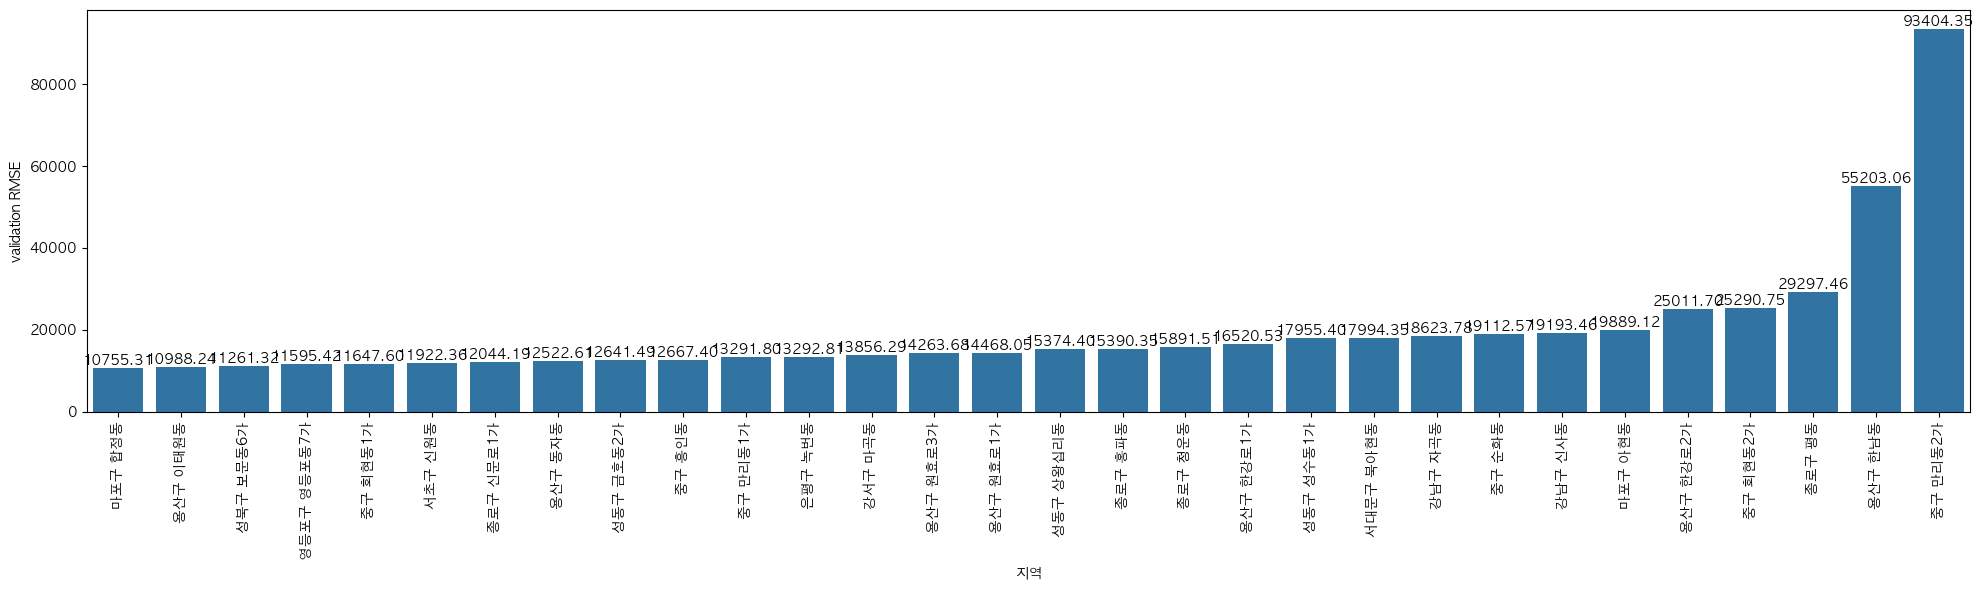

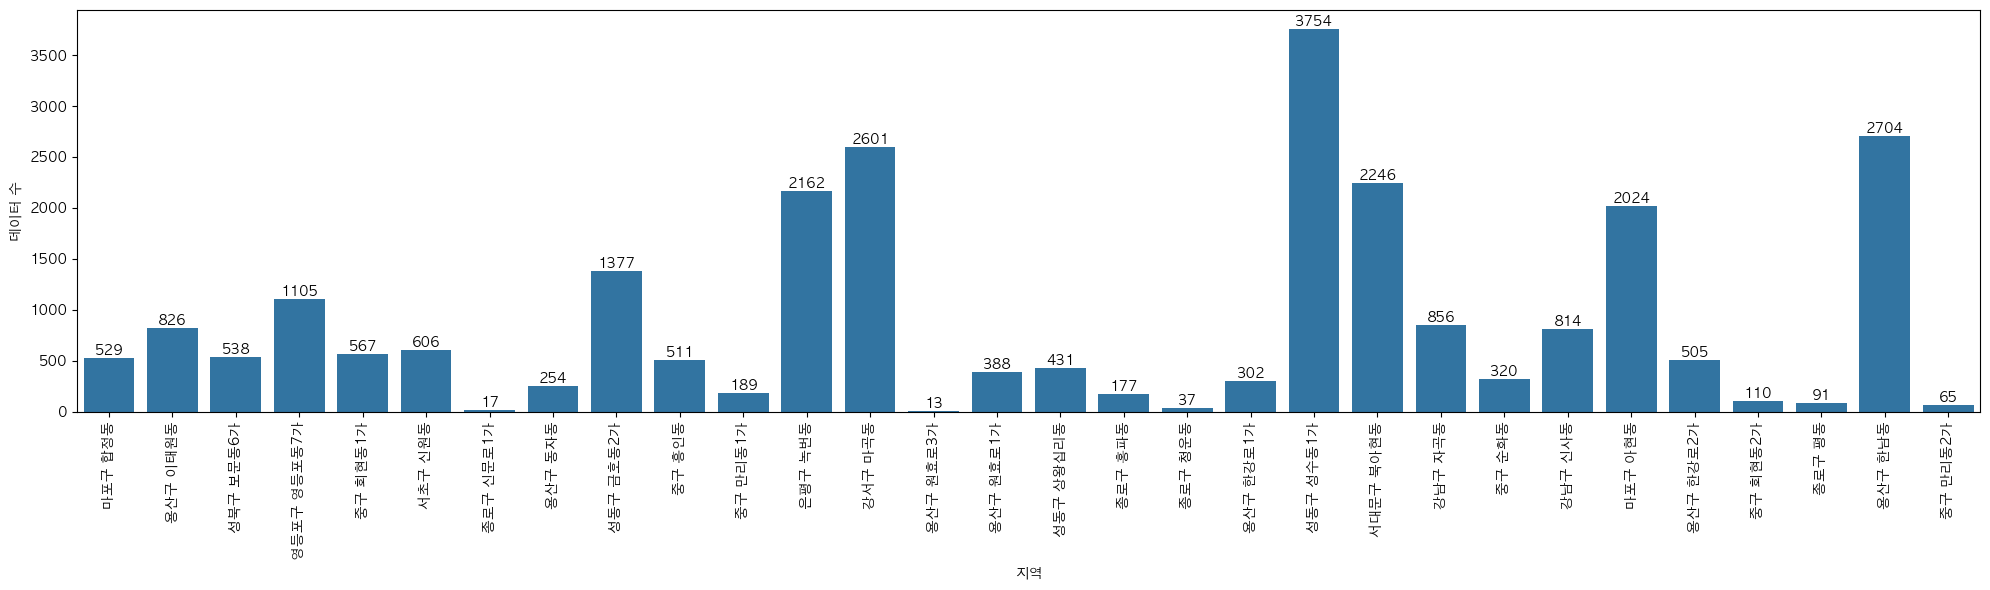

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [22]:
submit = result.sort_values(by = 'id')

display(result)

nan_val = 81300
submit['target'] = submit['target'].fillna(nan_val)

display(submit)
print(nan_val)
print(submit.isnull().sum())

submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_N_mean_features.csv', index=False)

,id,target
1118889,1118889,230061.030135
1118891,1118891,177644.212819
1118892,1118892,191429.360617
1118935,1118935,209968.702631
1118936,1118936,210936.510914
...,...,...
1127760,1127760,145291.773400
1127761,1127761,164155.331245
1127762,1127762,145291.773400
1127872,1127872,NaN


,id,target
1118822,1118822,175632.080296
1118823,1118823,234325.699899
1118824,1118824,170162.429561
1118825,1118825,172040.436524
1118826,1118826,166943.413509
...,...,...
1128089,1128089,70857.616930
1128090,1128090,68629.544664
1128091,1128091,70831.005188
1128092,1128092,68992.496159


81300
id        0
target    0
dtype: int64


In [ ]:
model.feat

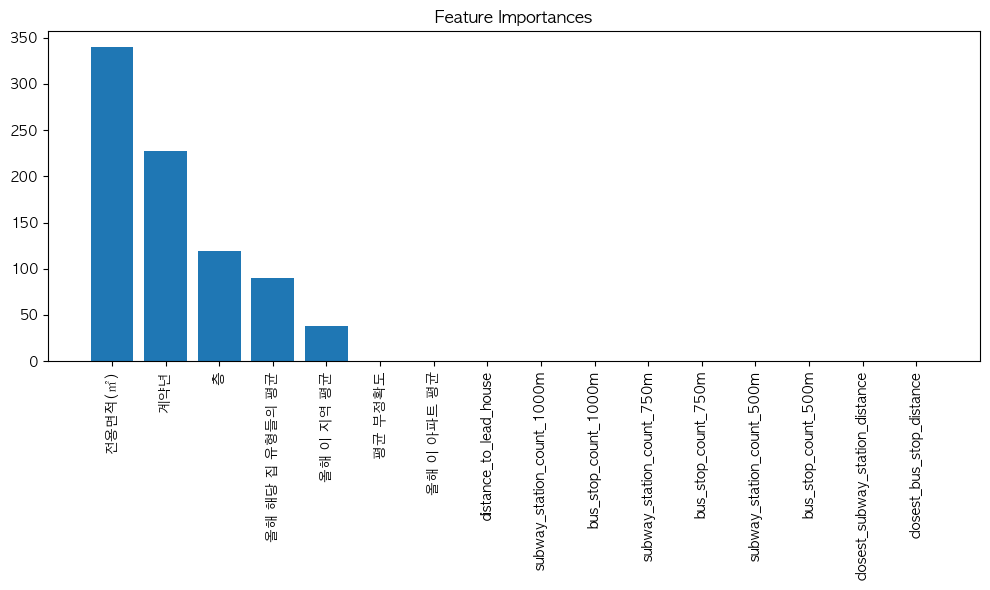

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()